In [2]:
%matplotlib ipympl
from models import *
# from models import find_index_of_nearest
from impedance.preprocessing import readCSV, readBioLogic
from impedance.visualization import plot_nyquist,plot_bode
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# from arbitau import give_z_for_arbitary_tau, tau_plotter
from scipy.integrate import solve_bvp

c:\Users\Gaming\AppData\Local\Programs\Python\Python311\Lib\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


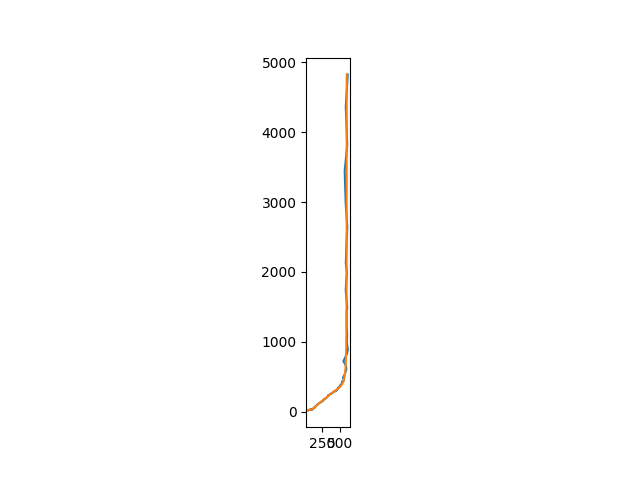

In [18]:
freq_list=np.logspace(-1,4,100)
#parameter for the TLM
Q=6.61e-4
alpha=1

R1=5.22*194.5
delta1=0.12
R2=3.47*194.5
delta2=0.17
R3=2.15*194.5


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=40
Rrxn=40
Qdl=1e-6
alpha2=1

cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")
zexp=cmodel.predict(frequencies=freq_list)
zexp_noise=np.real(zexp)+np.random.normal(0,0.02,(len(zexp)))*np.real(zexp)+(np.imag(zexp)+np.random.normal(0,0.02,(len(zexp)))*np.imag(zexp))*1j
fig, ax =plt.subplots()
# ax.plot([0,delta1,delta1,1],[R1,R1,R2,R2])
ax.plot(np.real(zexp_noise),-np.imag(zexp_noise))
ax.plot(np.real(zexp),-np.imag(zexp))
ax.set_aspect("equal")

In [16]:
a=np.random.normal(0,0.03)
a

-0.013505035916743083